In [2]:
import pandas as pd

df = pd.read_csv('/Users/keerthanap/Downloads/customer_data.csv')

print("Columns in the dataset:")
print(df.columns.tolist())

print("\nSample data:")
print(df.head())


Columns in the dataset:
['id', 'age', 'gender', 'income', 'education', 'region', 'loyalty_status', 'purchase_frequency', 'purchase_amount', 'product_category', 'promotion_usage', 'satisfaction_score']

Sample data:
   id  age  gender  income   education region loyalty_status  \
0   1   27    Male   40682    Bachelor   East           Gold   
1   2   29    Male   15317     Masters   West        Regular   
2   3   37    Male   38849    Bachelor   West         Silver   
3   4   30    Male   11568  HighSchool  South        Regular   
4   5   31  Female   46952     College  North        Regular   

  purchase_frequency  purchase_amount product_category  promotion_usage  \
0           frequent            18249            Books                0   
1               rare             4557         Clothing                1   
2               rare            11822         Clothing                0   
3           frequent             4098             Food                0   
4         occasional     

Loaded dataset with shape: (100000, 12)
Columns: ['id', 'age', 'gender', 'income', 'education', 'region', 'loyalty_status', 'purchase_frequency', 'purchase_amount', 'product_category', 'promotion_usage', 'satisfaction_score']

Data types:
 id                     int64
age                    int64
gender                object
income                 int64
education             object
region                object
loyalty_status        object
purchase_frequency    object
purchase_amount        int64
product_category      object
promotion_usage        int64
satisfaction_score     int64
dtype: object

Missing values:
 id                    0
age                   0
gender                0
income                0
education             0
region                0
loyalty_status        0
purchase_frequency    0
purchase_amount       0
product_category      0
promotion_usage       0
satisfaction_score    0
dtype: int64
Created proxy columns (because they were missing): ['browsing_time', 'past_purc

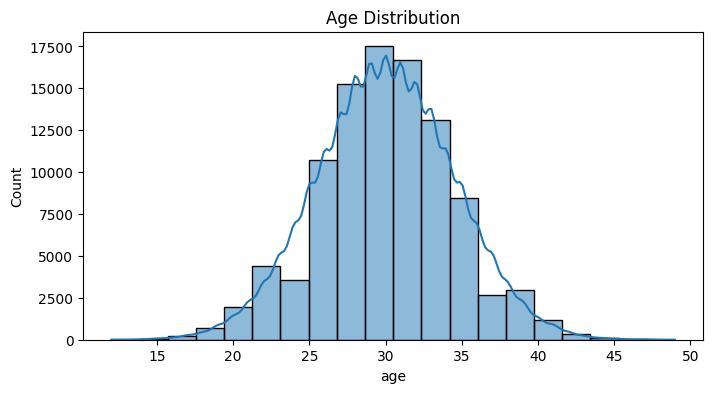

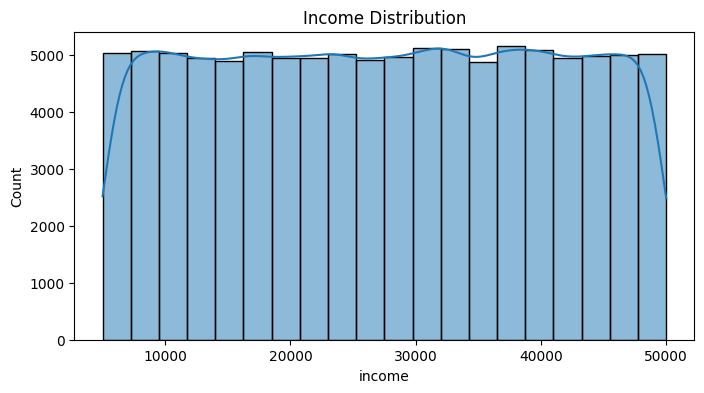

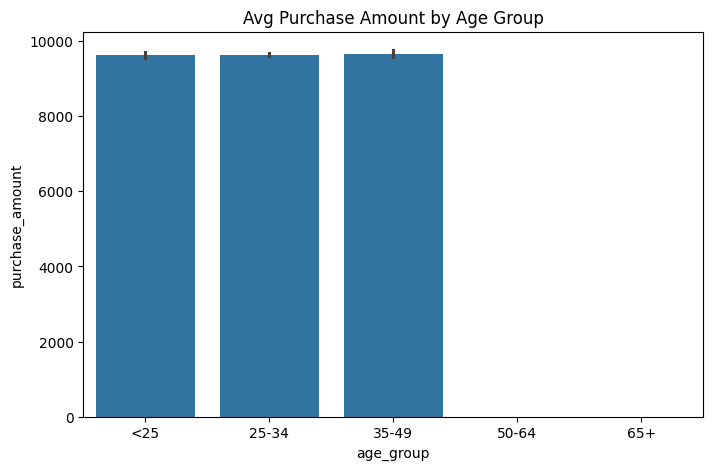

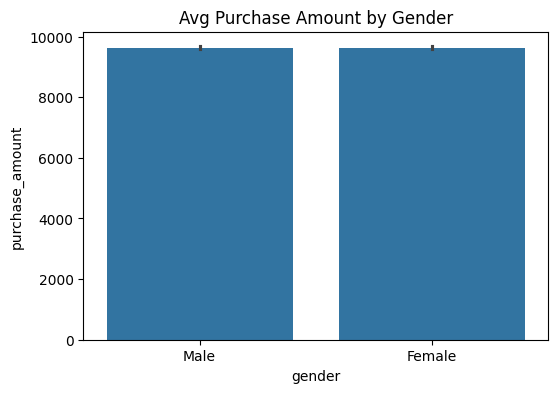

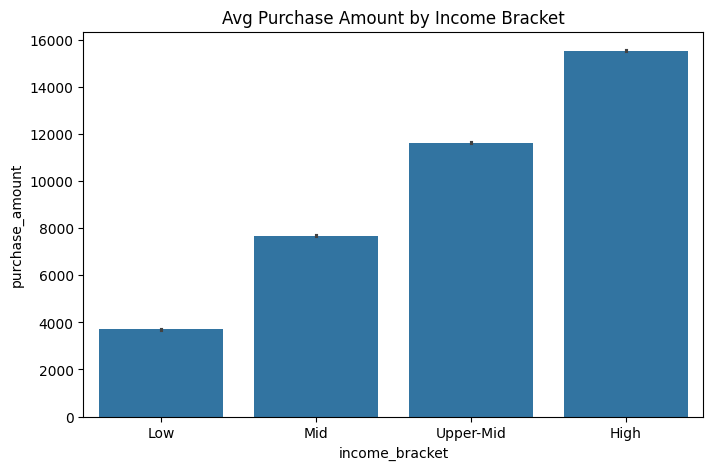


--- Behavioral Analysis ---


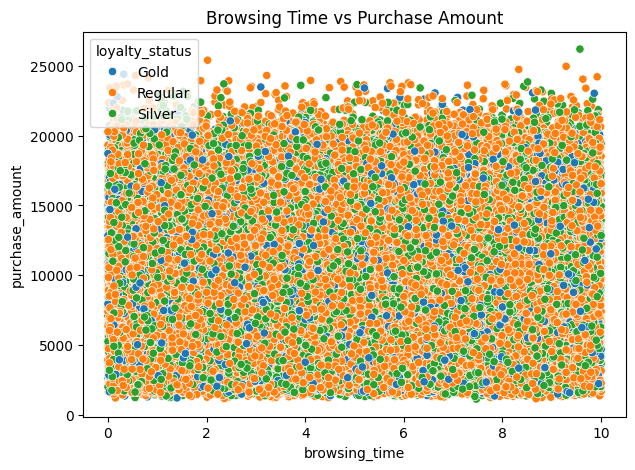

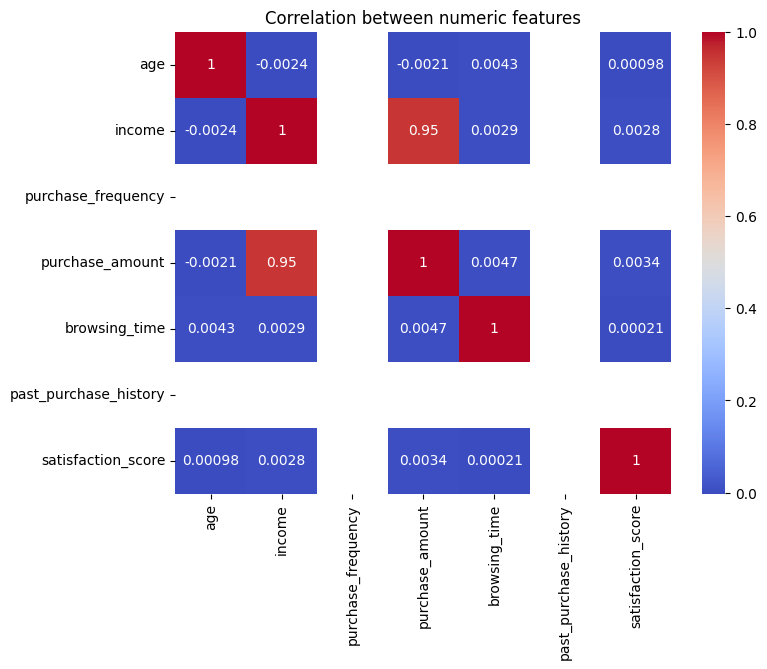

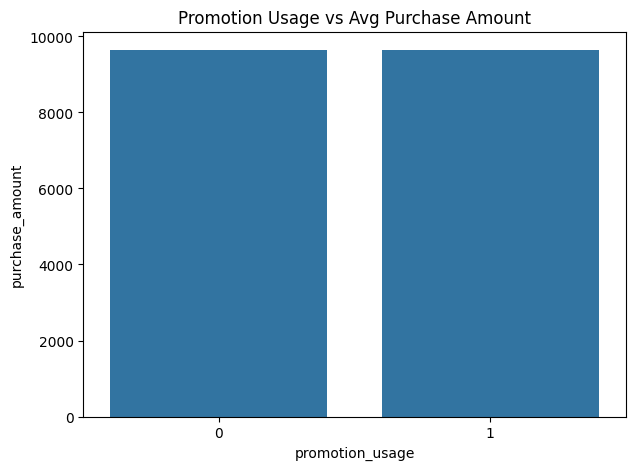


--- Customer Segmentation (KMeans) ---


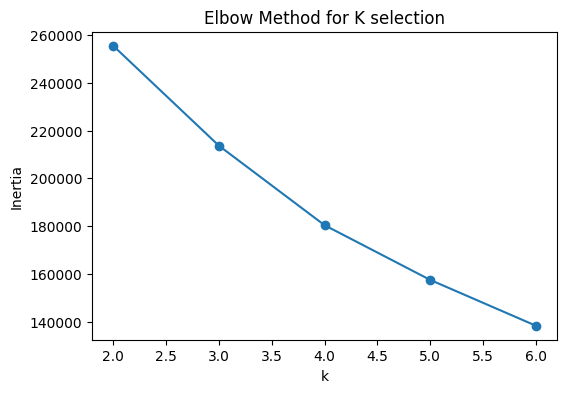


Cluster centers (scaled features mean approx):
            age    income  purchase_frequency  purchase_amount  browsing_time  \
cluster                                                                        
0        30.00  40115.49                 NaN         14213.07           5.03   
1        29.90  18075.52                 NaN          6193.10           2.37   
2        30.11  17869.77                 NaN          6140.62           7.57   

         past_purchase_history  
cluster                         
0                          0.0  
1                          0.0  
2                          0.0  


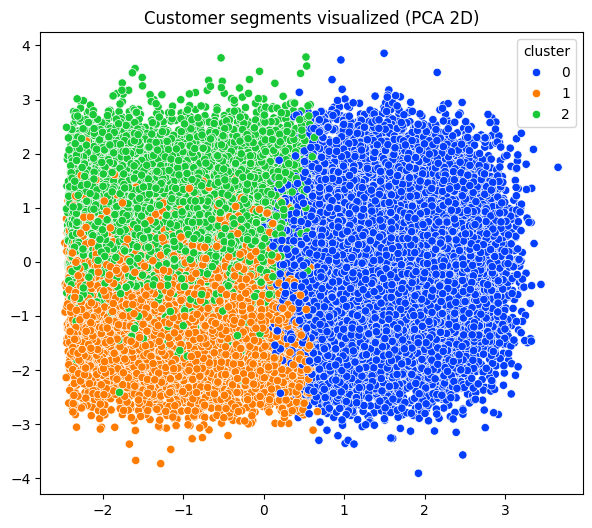


Cluster heuristics (cluster, avg_amount, avg_freq, avg_browsing):
(np.int32(0), np.float64(14213.068584686775), nan, np.float64(5.0323023201856145))
(np.int32(1), np.float64(6193.097829903785), nan, np.float64(2.3725086031322427))
(np.int32(2), np.float64(6140.62303849131), nan, np.float64(7.565692421363732))

Cluster label mapping: {0: 'High Spenders', 1: 'Moderate Buyers', 2: 'Browsers/Occasional'}

--- Sentiment Analysis (product_reviews) ---
No product_reviews present or all empty — skipping sentiment analysis.

--- Predictive Modeling ---
Purchase amount regression - RMSE: 1618.7961699164705
Purchase amount regression - R2: 0.8856892375229842

Regression feature importances:
 income                   0.940615
browsing_time            0.039878
age                      0.019507
purchase_frequency       0.000000
past_purchase_history    0.000000
dtype: float64

Satisfaction classification - Accuracy: 0.9342
Classification report:
               precision    recall  f1-score   suppor

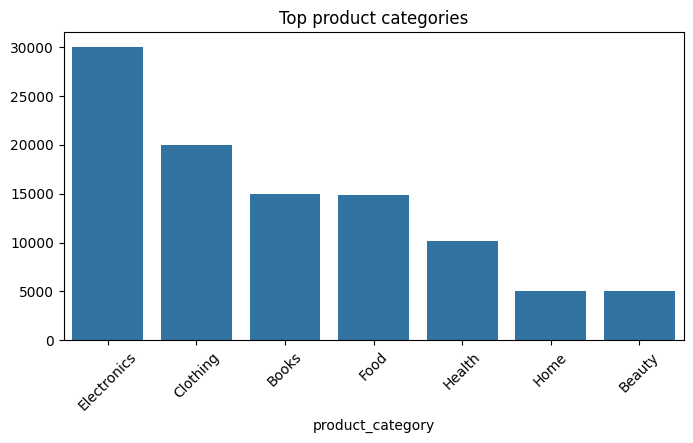


Avg purchase by cluster_label:
 cluster_label
High Spenders          14213.068585
Moderate Buyers         6193.097830
Browsers/Occasional     6140.623038
Name: purchase_amount, dtype: float64
Recommendation: target High Spenders with premium offerings; target lower-purchase clusters with promotions/discounts.

--- Summary of Outputs ---
1) KMeans clusters assigned in column 'cluster' and human label in 'cluster_label'.
2) Regression model for purchase_amount trained. RMSE and R2 printed above.
3) Classification model for satisfaction (binary) trained. Accuracy & report printed above.
4) Purchase likelihood model trained. Accuracy & AUC printed above.
5) Sentiment classifier trained on product_reviews if present.

You can now:
- Inspect df.head() for cluster & new features.
- Save models (sklearn) via joblib if you'd like.
- Create targeted marketing segments using 'cluster_label' and 'income_bracket'.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

file_path ='/Users/keerthanap/Downloads/customer_data.csv'  
random_state = 42
np.random.seed(random_state)


def safe_read_csv(path):
    df = pd.read_csv(path)
    return df

def ensure_cols(df, cols_with_defaults):
    """
    cols_with_defaults: dict col -> default_factory(value or callable)
    Returns df, created_columns_list
    """
    created = []
    for c, default in cols_with_defaults.items():
        if c not in df.columns:
            if callable(default):
                df[c] = default()
            else:
                df[c] = default
            created.append(c)
    return df, created

def binarize_satisfaction(df, col="satisfaction_score", threshold=3):
    """
    Create binary label 'satisfied' where 1 if score > threshold else 0.
    If satisfaction_score not numeric, attempts to convert.
    """
    if col not in df.columns:
        return df, False
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df['satisfied'] = (df[col] > threshold).astype(int)
    return df, True

def show_corr_heatmap(df, numeric_cols):
    plt.figure(figsize=(8,6))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation between numeric features")
    plt.show()

df = safe_read_csv(file_path)
print("Loaded dataset with shape:", df.shape)
print("Columns:", df.columns.tolist())

df.columns = [c.strip() for c in df.columns]

for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].str.strip()

print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())


def make_browsing_time_proxy():
    if 'purchase_frequency' in df.columns:
        pf = pd.to_numeric(df['purchase_frequency'], errors='coerce').fillna(0)
        return (pf * 5 + np.random.rand(len(df)) * 10).round(2)
    else:
        return np.random.rand(len(df)) * 10

def make_past_purchase_history_proxy():
    freq = pd.to_numeric(df['purchase_frequency'], errors='coerce').fillna(0) if 'purchase_frequency' in df.columns else 0
    amt = pd.to_numeric(df['purchase_amount'], errors='coerce').fillna(0) if 'purchase_amount' in df.columns else 0
    return (freq * np.clip(amt / (amt.mean() + 1e-6), 0.5, 2)).round(2)

cols_defaults = {
    'browsing_time': make_browsing_time_proxy,     
    'past_purchase_history': make_past_purchase_history_proxy,  
    'product_reviews': lambda : np.nan 
}
df, created_cols = ensure_cols(df, cols_defaults)
if created_cols:
    print("Created proxy columns (because they were missing):", created_cols)

if 'id' not in df.columns:
    df.insert(0, 'id', range(1, len(df)+1))
    print("Created 'id' column")

# Convert numeric columns
num_cols = ['age', 'income', 'purchase_frequency', 'purchase_amount', 'browsing_time', 'past_purchase_history', 'satisfaction_score']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

for c in num_cols:
    if c in df.columns:
        med = df[c].median()
        df[c] = df[c].fillna(med)

# ---------- Demographic Analysis ----------
print("\n--- Demographic Analysis ---")
# Age distribution
plt.figure(figsize=(8,4))
sns.histplot(df['age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['income'], bins=20, kde=True)
plt.title("Income Distribution")
plt.show()

df['age_group'] = pd.cut(df['age'], bins=[0,25,35,50,65,100], labels=['<25','25-34','35-49','50-64','65+'])
df['income_bracket'] = pd.qcut(df['income'].rank(method='first'), q=4, labels=['Low','Mid','Upper-Mid','High'])

plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='purchase_amount', data=df, estimator=np.mean)
plt.title("Avg Purchase Amount by Age Group")
plt.show()

if 'gender' in df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(x='gender', y='purchase_amount', data=df, estimator=np.mean)
    plt.title("Avg Purchase Amount by Gender")
    plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='income_bracket', y='purchase_amount', data=df, estimator=np.mean)
plt.title("Avg Purchase Amount by Income Bracket")
plt.show()

# ---------- Behavioral Analysis ----------
print("\n--- Behavioral Analysis ---")
plt.figure(figsize=(7,5))
sns.scatterplot(x='browsing_time', y='purchase_amount', hue='loyalty_status' if 'loyalty_status' in df.columns else None, data=df)
plt.title("Browsing Time vs Purchase Amount")
plt.show()

num_present = [c for c in num_cols if c in df.columns]
show_corr_heatmap(df, num_present)

if 'promotion_usage' in df.columns:
    plt.figure(figsize=(7,5))
    sns.barplot(x='promotion_usage', y='purchase_amount', data=df, ci=None)
    plt.title("Promotion Usage vs Avg Purchase Amount")
    plt.show()

# ---------- Customer Segmentation (KMeans) ----------
print("\n--- Customer Segmentation (KMeans) ---")
cluster_features = ['age', 'income', 'purchase_frequency', 'purchase_amount', 'browsing_time', 'past_purchase_history']
cluster_features = [c for c in cluster_features if c in df.columns]

X_cluster = df[cluster_features].fillna(0).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

inertia = []
K_range = range(2,7)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for K selection')
plt.show()

k = 3
km = KMeans(n_clusters=k, random_state=random_state, n_init=20)
df['cluster'] = km.fit_predict(X_scaled)

cluster_summary = df.groupby('cluster')[cluster_features].mean().round(2)
print("\nCluster centers (scaled features mean approx):\n", cluster_summary)

# Use PCA for 2D visualisation
pca = PCA(n_components=2, random_state=random_state)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(7,6))
palette = sns.color_palette('bright', k)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette=palette)
plt.title("Customer segments visualized (PCA 2D)")
plt.show()

cluster_meta = []
for cl in sorted(df['cluster'].unique()):
    row = df[df['cluster'] == cl]
    avg_amt = row['purchase_amount'].mean()
    avg_freq = row['purchase_frequency'].mean() if 'purchase_frequency' in df.columns else 0
    avg_browse = row['browsing_time'].mean()
    cluster_meta.append((cl, avg_amt, avg_freq, avg_browse))
print("\nCluster heuristics (cluster, avg_amount, avg_freq, avg_browsing):")
for t in cluster_meta:
    print(t)

cluster_by_amt = df.groupby('cluster')['purchase_amount'].mean().sort_values(ascending=False)
label_map = {}
labels = ['High Spenders', 'Moderate Buyers', 'Browsers/Occasional']
for i, cl in enumerate(cluster_by_amt.index):
    label_map[cl] = labels[i] if i < len(labels) else f"Cluster_{cl}"
df['cluster_label'] = df['cluster'].map(label_map)
print("\nCluster label mapping:", label_map)

# ---------- Sentiment Analysis on product_reviews ----------
print("\n--- Sentiment Analysis (product_reviews) ---")
if 'product_reviews' in df.columns and df['product_reviews'].notna().sum() > 0:
    df_reviews = df[['product_reviews', 'satisfaction_score', 'satisfied']].copy()
    df_reviews.dropna(subset=['product_reviews'], inplace=True)
    df_reviews['product_reviews'] = df_reviews['product_reviews'].astype(str)

    df_reviews, _ = binarize_satisfaction(df_reviews, 'satisfaction_score', threshold=3)

    X_rev = df_reviews['product_reviews']
    y_rev = df_reviews['satisfied']

    from sklearn.model_selection import train_test_split
    Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_rev, y_rev, test_size=0.2, random_state=random_state, stratify=y_rev)
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    pipe.fit(Xr_train, yr_train)
    preds = pipe.predict(Xr_test)
    print("Sentiment classifier accuracy on test set:", accuracy_score(yr_test, preds))
    print(classification_report(yr_test, preds))
else:
    print("No product_reviews present or all empty — skipping sentiment analysis.")

# ---------- Predictive Modeling ----------
print("\n--- Predictive Modeling ---")

# 1) Predict purchase_amount (regression)
reg_target = 'purchase_amount'
reg_features = ['age', 'income', 'purchase_frequency', 'browsing_time', 'past_purchase_history']
reg_features = [c for c in reg_features if c in df.columns]
X = df[reg_features].fillna(0)
y = df[reg_target].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
reg = RandomForestRegressor(n_estimators=200, random_state=random_state)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Purchase amount regression - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Purchase amount regression - R2:", r2_score(y_test, y_pred))

fi = pd.Series(reg.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRegression feature importances:\n", fi)

# 2) Predict satisfaction_score (classification - binary satisfied)
clf_target = 'satisfied'
df, _ = binarize_satisfaction(df, 'satisfaction_score', threshold=3)
clf_features = ['age', 'income', 'purchase_frequency', 'purchase_amount', 'browsing_time', 'past_purchase_history', 'promotion_usage']
clf_features = [c for c in clf_features if c in df.columns]

Xc = df[clf_features].fillna(0)
yc = df[clf_target].fillna(0).astype(int)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=random_state, stratify=yc)
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)
print("\nSatisfaction classification - Accuracy:", accuracy_score(yc_test, yc_pred))
print("Classification report:\n", classification_report(yc_test, yc_pred))
print("Confusion matrix:\n", confusion_matrix(yc_test, yc_pred))

fi_clf = pd.Series(clf.feature_importances_, index=Xc.columns).sort_values(ascending=False)
print("\nClassification feature importances:\n", fi_clf)

# ---------- Predict likelihood of purchase/churn ----------
print("\n--- Purchase / Churn Likelihood ---")
df['made_purchase'] = (df['purchase_amount'] > 0).astype(int)

churn_features = ['browsing_time', 'past_purchase_history', 'age', 'income', 'loyalty_status']
churn_features = [c for c in churn_features if c in df.columns]
Xch = df[churn_features].copy()
if 'loyalty_status' in Xch.columns:
    Xch['loyalty_status_enc'] = LabelEncoder().fit_transform(Xch['loyalty_status'].astype(str))
    Xch.drop(columns=['loyalty_status'], inplace=True)
y_ch = df['made_purchase']

Xch_train, Xch_test, ych_train, ych_test = train_test_split(Xch.fillna(0), y_ch, test_size=0.2, random_state=random_state, stratify=y_ch)
churn_clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
churn_clf.fit(Xch_train, ych_train)
ych_pred = churn_clf.predict(Xch_test)
print("Purchase likelihood accuracy:", accuracy_score(ych_test, ych_pred))

# Safely compute AUC only if both classes exist
if hasattr(churn_clf, "predict_proba"):
    proba = churn_clf.predict_proba(Xch_test)
    if proba.shape[1] == 2:  # normal binary case
        auc_score = roc_auc_score(ych_test, proba[:, 1])
        print("AUC (approx):", auc_score)
    else:
        print("⚠️ AUC not computed: only one class present in y_test.")
else:
    print("⚠️ Model has no predict_proba method, skipping AUC.")

fi_churn = pd.Series(churn_clf.feature_importances_, index=Xch.columns).sort_values(ascending=False)
print("\nPurchase likelihood feature importances:\n", fi_churn)

# ---------- Marketing Insights ----------
print("\n--- Marketing Insights (automated) ---")
# 1) Which demographics respond best to promotions?
if 'promotion_usage' in df.columns:
    # Assume 'promotion_usage' is categorical or numeric count
    promo_summary = df.groupby('income_bracket').apply(lambda d: d[d['promotion_usage']>0]['purchase_amount'].mean())
    print("\nAvg purchase amount among promotion users by income bracket:\n", promo_summary)
else:
    print("promotion_usage column missing; cannot compute promotion response insights.")

# 2) Which product categories are dominant?
if 'product_category' in df.columns:
    top_cats = df['product_category'].value_counts().head(10)
    print("\nTop product categories:\n", top_cats)
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_cats.index, y=top_cats.values)
    plt.xticks(rotation=45)
    plt.title("Top product categories")
    plt.show()
else:
    print("product_category column missing; skipping category insights.")

# 3) Which cluster to target with discounts?
cluster_purchase = df.groupby('cluster_label')['purchase_amount'].mean().sort_values(ascending=False)
print("\nAvg purchase by cluster_label:\n", cluster_purchase)
print("Recommendation: target", cluster_purchase.idxmax(), "with premium offerings; target lower-purchase clusters with promotions/discounts.")

# ---------- Final Summary ----------
print("\n--- Summary of Outputs ---")
print("1) KMeans clusters assigned in column 'cluster' and human label in 'cluster_label'.")
print("2) Regression model for purchase_amount trained. RMSE and R2 printed above.")
print("3) Classification model for satisfaction (binary) trained. Accuracy & report printed above.")
print("4) Purchase likelihood model trained. Accuracy & AUC printed above.")
print("5) Sentiment classifier trained on product_reviews if present.")
print("\nYou can now:")
print("- Inspect df.head() for cluster & new features.")
print("- Save models (sklearn) via joblib if you'd like.")
print("- Create targeted marketing segments using 'cluster_label' and 'income_bracket'.")
